# Real Estate Price Prediction

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime # для работы со времнем

from sklearn import ensemble
from matplotlib import style
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor


from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

style.use('fivethirtyeight')
%matplotlib inline



In [2]:
import warnings
warnings.filterwarnings('ignore')

# Чтение данных

In [3]:
TEST_DATASET_PATH = 'real-estate-price-prediction-moscow/test.csv'
TRAIN_DATASET_PATH = 'real-estate-price-prediction-moscow/train.csv'

X_final = pd.read_csv(TEST_DATASET_PATH)
X = pd.read_csv(TRAIN_DATASET_PATH)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

# 1. Минимальный EDA

### 1.1 Выбросы

**Rooms**

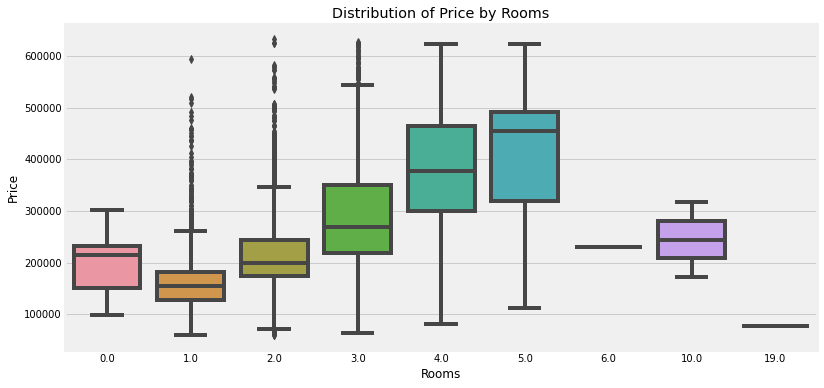

In [4]:
# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(X['Rooms'], X['Price'])
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Distribution of Price by Rooms')
plt.show();

**Square**

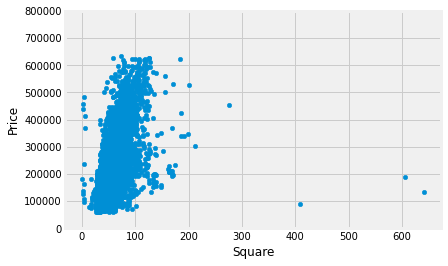

In [5]:
var = 'Square'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y='Price', ylim=(0,800000));

**LifeSquare**

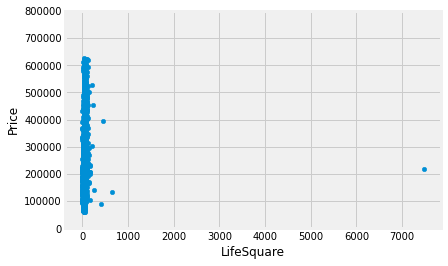

In [6]:
var = 'LifeSquare'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y='Price', ylim=(0,800000));

**Floor, HouseFloor**

In [7]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [8]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [9]:
(X['Floor'] > X['HouseFloor']).sum()

1825

**HouseYear**

In [10]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

### 1.2 Анализ количественных признаков

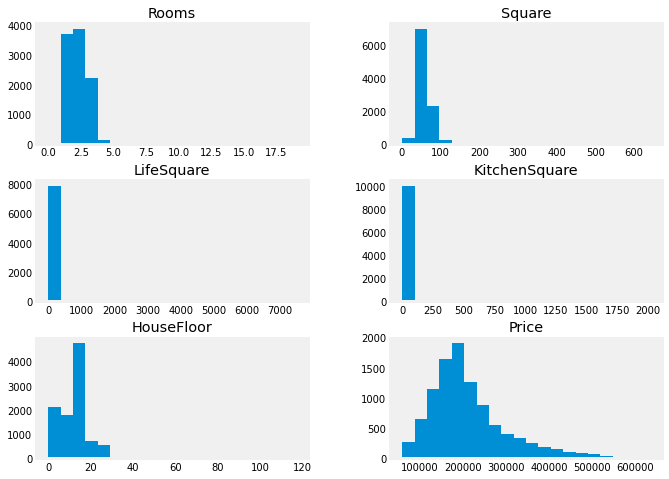

In [11]:
# отбираем количественные признаки
df_num_features = X.select_dtypes(include='float64')

# Удаляем малозначащие столбцы
num_features = pd.DataFrame(df_num_features)
num_features.drop("Ecology_1", axis=1, inplace=True)
num_features.drop("Healthcare_1", axis=1, inplace=True)
num_features.hist(figsize=(10, 8), bins=20, grid=False);

### 1.3 Корреляция признаков

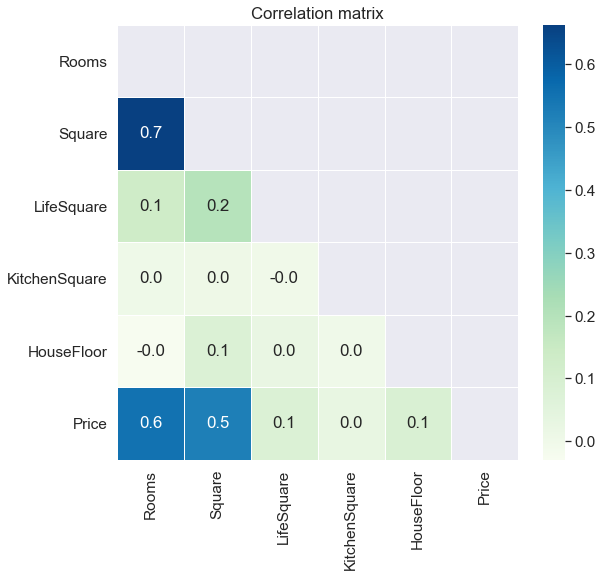

In [12]:
corr = num_features.corr()
plt.figure(figsize = (8, 8))
mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show();

In [13]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

## 2. Очистка данных

In [14]:
X = X.sort_values('Price')
X_final = X_final.sort_values('DistrictId')

In [15]:
# Удаляем выбросы Square
X.sort_values(by = 'Square', ascending = False)[:3]
X = X.drop(X[X['Id'] == 11602].index)
X = X.drop(X[X['Id'] == 28].index)
X = X.drop(X[X['Id'] == 2307].index)

In [16]:
# Удаляем выбросы HouseYear

X.sort_values(by = 'HouseYear', ascending = False)[:2]
X = X.drop(X[X['Id'] == 10814].index)
X = X.drop(X[X['Id'] == 11607].index)

In [17]:
# Удаляем выбросы Rooms

X.sort_values(by = 'Rooms', ascending = False)[:3]
X = X.drop(X[X['Id'] == 8491].index)
X = X.drop(X[X['Id'] == 5927].index)
X = X.drop(X[X['Id'] == 14865].index)

In [18]:
# Удаляем выбросы LifeSquare

X.sort_values(by = 'LifeSquare', ascending = False)[:4]
X = X.drop(X[X['Id'] == 16550].index)
X = X.drop(X[X['Id'] == 15886].index)
X = X.drop(X[X['Id'] == 14990].index)
X = X.drop(X[X['Id'] == 5548].index)
X = X.drop(X[X['Id'] == 7917].index)
X = X.drop(X[X['Id'] == 16568].index)

In [19]:
# Создаем класс для подчищения выбросов


class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] 
        X.loc[(X['Rooms'] > 5) & (X['Square'] < 50),'Rooms'] = 2
        
        # Square
        X.loc[X['Square'] < 10,'Square']= X.loc[X['Square'] < 10,'Square']*10
        X.loc[X['Square'] < 1,'Square'] = X.loc[X['Square']<1,'Square']*100 
        X.loc[X['Square'] > 250, 'Square'] = self.medians['Square'] 
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = self.medians['HouseYear']
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        X.loc[(X['LifeSquare'] > 200) &\
               (X['Square'] < 100),'LifeSquare']=X.loc[(X['LifeSquare']>200) & (X['Square']<100),'LifeSquare']/10
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] * 0.65
        
        
        return X
        

In [20]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)

In [21]:
# Заполняем NaN

X = X.sort_values('Price')
X_final = X_final.sort_values('DistrictId')
X = X.fillna(method='pad')
X_final = X_final.fillna(method='pad')

In [22]:
y = X.Price
X.drop("Price", axis=1, inplace=True)
X.drop("Id", axis=1, inplace=True)


## 3. Проверка данных

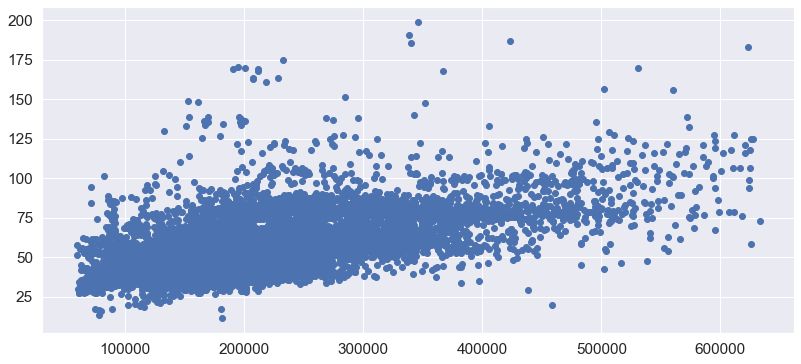

In [23]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

plt.scatter(y, X.Square)

## 4. Модель

In [24]:
X = pd.get_dummies(X)

In [26]:
model = RandomForestRegressor(n_estimators=300, max_depth=18, random_state=42, max_features=7)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.741 +- 0.016


In [27]:
model.fit(X, y)

RandomForestRegressor(max_depth=18, max_features=7, n_estimators=300,
                      random_state=42)

## 5. Предсказание и выгрузка в файл

In [28]:
X_test = pd.get_dummies(X_final)
X_test.drop("Id", axis=1, inplace=True)



X_final["Price"] = model.predict(X_test)
X_final.loc[:, ['Id', 'Price']].to_csv('predictionsVR.csv', index=False)
X_final.loc[:, ['Id', 'Price']].head(20)


,Id,Price
4445,6675,216584.265280
3226,3260,177005.379531
2154,9924,232948.502471
4924,6456,186864.495383
1046,4834,203739.165064
1801,4836,240288.327483
1285,14681,196269.238418
4329,11838,120505.311566
2330,6663,190240.375626
3102,7319,149188.423333
